In [87]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from PIL import Image, ImageDraw, ImageGrab
import colorsys
import time
import moviepy.editor as mpe
import cv2
import json
import os


from config import chemin_pipeline, chemin_tt_espace, lien_bdd, USER_PREFERENCE

In [88]:
import sqlite3
import pandas as pd


con = sqlite3.connect(lien_bdd)

In [89]:
joueurA = "ALEXIS-LEBRUN"

In [90]:
requete = f"SELECT * FROM Liste_des_coups WHERE nom = "+"\'"+joueurA+"\'" + " AND Gamename  = 'ALEXIS-LEBRUN_vs_MA-LONG'"
df = pd.read_sql_query(requete, con)
annotations = df.values.tolist()
print(df.head())
decalage_index_bdd = 5

   IdMatch              competition                  Gamename  IdCoup  IttfId  \
0       25  2024_WttSmash_Singapour  ALEXIS-LEBRUN_vs_MA-LONG       0  132992   
1       25  2024_WttSmash_Singapour  ALEXIS-LEBRUN_vs_MA-LONG       2  132992   
2       25  2024_WttSmash_Singapour  ALEXIS-LEBRUN_vs_MA-LONG       4  132992   
3       25  2024_WttSmash_Singapour  ALEXIS-LEBRUN_vs_MA-LONG       6  132992   
4       25  2024_WttSmash_Singapour  ALEXIS-LEBRUN_vs_MA-LONG       9  132992   

             nom  debut  fin   genre  lateralite  ...  pos_joueur_1_frappe_z  \
0  ALEXIS-LEBRUN      0   57  garcon  coup_droit  ...                     i4   
1  ALEXIS-LEBRUN     73   82  garcon      revers  ...                     g5   
2  ALEXIS-LEBRUN    322  339  garcon  coup_droit  ...                     h5   
3  ALEXIS-LEBRUN    354  364  garcon  coup_droit  ...                     g6   
4  ALEXIS-LEBRUN    784  795  garcon  coup_droit  ...                     g5   

  pos_joueur_0_fin_x pos_joueur_

In [91]:
def afficher_densite_frappes(annotations): 
    #extraction positions joueur + balle + info si le joueur est en haut ou en bas (change à chaque set)
    positions_1=[]
    positions_2=[]
    cote_jA = 81+decalage_index_bdd
    cote_jB = 82+decalage_index_bdd
    joueur_frappe = 16+decalage_index_bdd
    coor_frappe_x = 18+decalage_index_bdd
    coor_frappe_y = 19+decalage_index_bdd
    pos_joueur_0_x = 35+decalage_index_bdd
    pos_joueur_1_x = 38+decalage_index_bdd
    pos_joueur_0_y = 36+decalage_index_bdd
    pos_joueur_1_y = 39+decalage_index_bdd
    num_coup = 27+decalage_index_bdd
    for i in range(len(annotations)):
        if annotations[i][cote_jA]=='haut' and annotations[i][joueur_frappe]==joueurA: # l17 : joueur_frappe
            positions_1.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_0_x]),-float(annotations[i][pos_joueur_0_y]),'haut', annotations[i][num_coup]]) #x_balle, y_balle, x_joueur, y_joueur, cote_joueur, num_coup
        elif annotations[i][cote_jA]=='bas' and annotations[i][joueur_frappe]==joueurA:
            positions_1.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_0_x]),-float(annotations[i][pos_joueur_0_y]),'bas', annotations[i][num_coup]])
        elif annotations[i][cote_jB]=='haut' and annotations[i][joueur_frappe]!=joueurA:
            positions_2.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_1_x]),-float(annotations[i][pos_joueur_1_y]),'haut', annotations[i][num_coup]])
        elif annotations[i][cote_jB]=='bas' and annotations[i][joueur_frappe]!=joueurA:
            positions_2.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_1_x]),-float(annotations[i][pos_joueur_1_y]),'bas', annotations[i][num_coup]])


    im_table_env=Image.open("environnement_demie_table.png").convert('RGB')
    W_im_env, h_im_env=im_table_env.size


    size=10
    R=25


    im_table_env_densite_jA=im_table_env.copy()
    px_table_env_jA=im_table_env_densite_jA.load()
    g=255
    b=255
    
    for i in range(len(positions_1)):
        if positions_1[i][4]=='bas':
            x_jA=positions_1[i][2]+W_im_env/2
            y_jA=-positions_1[i][3]     
        elif positions_1[i][4]=='haut':
            x_jA=-positions_1[i][2]+W_im_env/2
            y_jA=positions_1[i][3]
        
        for l in range(2*R):
            for L in range(2*R):
                if (L-R)**2+(l-R)**2<R**2:
                    if x_jA+L-R<W_im_env and y_jA+l-R<h_im_env and x_jA+L-R>0 and y_jA+l-R>0:
                        g=int(px_table_env_jA[x_jA+L-R,y_jA+l-R][1]-18)
                        b=int(px_table_env_jA[x_jA+L-R,y_jA+l-R][2]-18)
                        if g>0 and b>0:
                            im_table_env_densite_jA.putpixel([int(x_jA+L-R),int(y_jA+l-R)],(int(255),g,b))
                            px_table_env_jA=im_table_env_densite_jA.load()

    plt.imshow(im_table_env_densite_jA)
    plt.axis('off')
    plt.title('densité de présence de {}'.format(joueurA))

[[5.203843307495117, 154.060449608167, 72.07794189453125, 122.94302368164062, 'haut', 1], [19.11669158935547, 159.2676673412323, 76.073486328125, 221.22903442382807, 'haut', 3], [-9.465325927734376, 178.9335250218709, 100.875732421875, 168.52871704101562, 'haut', 1], [-57.34247531890869, 156.10150039990742, 73.6322021484375, 202.18051147460935, 'haut', 3], [-3.5504901885986326, 92.07839730580648, 69.73699951171875, 186.5047912597656, 'haut', 2], [41.38636093139648, 175.4087450345357, 75.39349365234375, 265.3941650390625, 'haut', 4], [24.5138298034668, 98.51657784779869, 52.94000244140625, 179.97964477539062, 'haut', 2], [16.752462005615236, 163.79362023671467, 122.004638671875, 125.85086059570312, 'haut', 1], [-115.84212894439698, 153.83231573899587, 60.92919921875, 216.409912109375, 'haut', 3], [-27.04638519287109, 207.791446908315, 73.77191162109375, 193.0152282714844, 'haut', 5], [-79.13377120494843, 175.62552947998046, -42.78265380859375, 190.82321166992188, 'haut', 1], [-95.276434

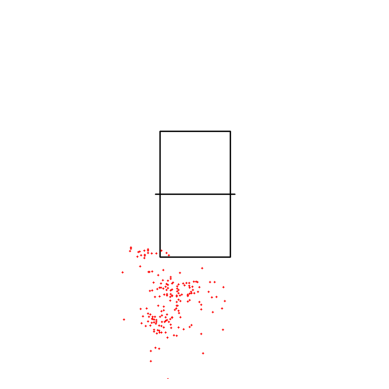

In [92]:
def afficher_frappes(annotations): 
    #extraction positions joueur + balle + info si le joueur est en haut ou en bas (change à chaque set)
    positions_1=[]
    positions_2=[]
    cote_jA = 81+decalage_index_bdd
    cote_jB = 82+decalage_index_bdd
    joueur_frappe = 16+decalage_index_bdd
    coor_frappe_x = 18+decalage_index_bdd
    coor_frappe_y = 19+decalage_index_bdd
    pos_joueur_0_x = 35+decalage_index_bdd
    pos_joueur_1_x = 38+decalage_index_bdd
    pos_joueur_0_y = 36+decalage_index_bdd
    pos_joueur_1_y = 39+decalage_index_bdd
    num_coup = 27+decalage_index_bdd
    for i in range(len(annotations)):
        if annotations[i][cote_jA]=='haut' and annotations[i][joueur_frappe]==joueurA: # l17 : joueur_frappe
            positions_1.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_0_x]),-float(annotations[i][pos_joueur_0_y]),'haut', annotations[i][num_coup]]) #x_balle, y_balle, x_joueur, y_joueur, cote_joueur, num_coup
        elif annotations[i][cote_jA]=='bas' and annotations[i][joueur_frappe]==joueurA:
            positions_1.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_0_x]),-float(annotations[i][pos_joueur_0_y]),'bas', annotations[i][num_coup]])
        elif annotations[i][cote_jB]=='haut' and annotations[i][joueur_frappe]!=joueurA:
            positions_2.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_1_x]),-float(annotations[i][pos_joueur_1_y]),'haut', annotations[i][num_coup]])
        elif annotations[i][cote_jB]=='bas' and annotations[i][joueur_frappe]!=joueurA:
            positions_2.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_1_x]),-float(annotations[i][pos_joueur_1_y]),'bas', annotations[i][num_coup]])


    w,h = 800, 800
    image = np.ones((h, w, 3), dtype=np.uint8) * 255  

    print(positions_1)

    size=10
    R=25

    g=255
    b=255
    
    cv2.line(image, (int(400-152/2), int(400-272/2)), (int(400+152/2), int(400-272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400-152/2), int(400-272/2)), (int(400-152/2), int(400+272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400+152/2), int(400+272/2)), (int(400+152/2), int(400-272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400+152/2), int(400+272/2)), (int(400-152/2), int(400+272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400-152/2-10), int(400)), (int(400+152/2+10), int(400)), (0, 0, 0), 2)
    for i in range(len(positions_1)):
        if positions_1[i][4]=='bas':
            x_jA=positions_1[i][2]+w/2
            y_jA=-positions_1[i][3] + 400    
        elif positions_1[i][4]=='haut':
            x_jA=-positions_1[i][2]+w/2
            y_jA=positions_1[i][3] + 400
        cv2.circle(image, (int(x_jA), int(y_jA)), 2, (255,0,0), -1)
        
    cv2.imwrite("C:/Users/ReViVD/Downloads/frappe_rapport_table.jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(image)
    plt.axis('off')
    #plt.title('densité de présence de {}'.format(joueurA))

afficher_frappes(annotations)

[[5.203843307495117, 154.060449608167, 72.07794189453125, 122.94302368164062, 'haut', 1], [19.11669158935547, 159.2676673412323, 76.073486328125, 221.22903442382807, 'haut', 3], [-9.465325927734376, 178.9335250218709, 100.875732421875, 168.52871704101562, 'haut', 1], [-57.34247531890869, 156.10150039990742, 73.6322021484375, 202.18051147460935, 'haut', 3], [-3.5504901885986326, 92.07839730580648, 69.73699951171875, 186.5047912597656, 'haut', 2], [41.38636093139648, 175.4087450345357, 75.39349365234375, 265.3941650390625, 'haut', 4], [16.752462005615236, 163.79362023671467, 122.004638671875, 125.85086059570312, 'haut', 1], [-115.84212894439698, 153.83231573899587, 60.92919921875, 216.409912109375, 'haut', 3], [-27.04638519287109, 207.791446908315, 73.77191162109375, 193.0152282714844, 'haut', 5], [-79.13377120494843, 175.62552947998046, -42.78265380859375, 190.82321166992188, 'haut', 1], [-95.27643404006956, 112.53852084477742, -29.42730712890625, 211.84616088867188, 'haut', 3], [-198.0

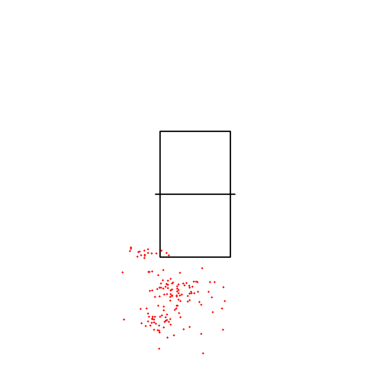

In [93]:
df = pd.read_sql_query(requete, con)
annotations_frappes_reussies = df[df["coor_balle_x"].notna()].values.tolist()

afficher_frappes(annotations_frappes_reussies)

[[24.5138298034668, 98.51657784779869, 52.94000244140625, 179.97964477539062, 'haut', 2], [51.84376831054688, 204.87394819259643, 51.39556884765625, 289.8351287841797, 'haut', 9], [29.06933898925781, 262.7294212341309, 85.062255859375, 332.9389343261719, 'haut', 5], [-118.41203289031982, 111.2547577381134, 4.62847900390625, 207.24417114257807, 'haut', 4], [-29.488943099975582, 202.38151718775435, 72.361572265625, 285.5404968261719, 'haut', 7], [-50.98217849731445, 294.9100110371908, 96.7479248046875, 260.0911865234375, 'haut', 3], [-50.21404886245728, 225.1831844965617, 39.65093994140625, 306.95269775390625, 'haut', 8], [-165.79485931396485, 307.07983347574867, 72.8465576171875, 253.7220001220703, 'haut', 9], [36.61292114257813, 200.8349034309387, 112.02069091796876, 264.9965057373047, 'haut', 7], [-103.9408697128296, -195.4146041870117, -49.4605712890625, -267.97955322265625, 'bas', 6], [-124.66118640899658, -207.3610964457194, -71.328369140625, -276.7255859375, 'bas', 4], [-168.12474

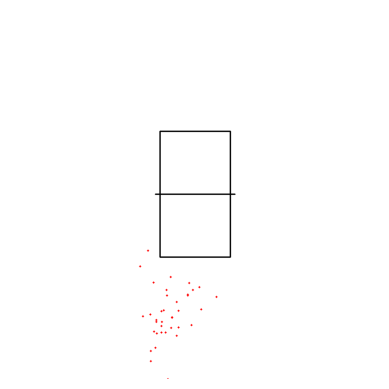

In [94]:
df = pd.read_sql_query(requete, con)
annotations_frappes_fautes = df[df["coor_balle_x"].isna()].values.tolist()

afficher_frappes(annotations_frappes_fautes)

(-0.5, 799.5, 799.5, -0.5)

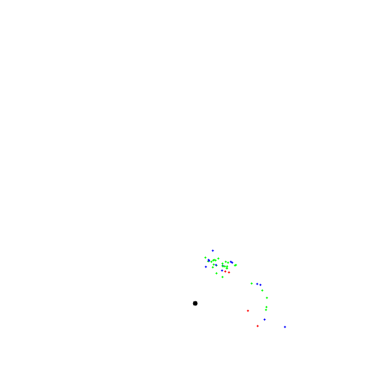

In [95]:
w,h = 800, 800
df_qualite = pd.read_csv("C:/Users/ReViVD/Desktop/dataroom/pipeline-tt/2024_WttSmash_Singapour/ALEXIS-LEBRUN_vs_MA-LONG/ALEXIS-LEBRUN_vs_MA-LONG_annotation_qualite.csv")
size=5
"""image_jA=np.ones((height, width,3), np.uint8)*255
image_jA=Image.fromarray(image_jA)
image_jB=image_jA.copy()
draw_jA = ImageDraw.Draw(image_jA)
draw_jB = ImageDraw.Draw(image_jB)
xj, yj = width/2, height/2
draw_jA.ellipse((xj - size, yj - size, xj + size, yj + size), fill="black")
draw_jB.ellipse((xj - size, yj - size, xj + size, yj + size), fill="black")"""


image = np.ones((h, w, 3), dtype=np.uint8) * 255  
set_point=[] # num set, num pt
set_point.append([1,0])
for i in range(2,len(annotations)):
    if annotations[i][52+decalage_index_bdd]!=annotations[i-1][52+decalage_index_bdd]:
        set_point.append([int(annotations[i][5+decalage_index_bdd]), int(annotations[i][52+decalage_index_bdd])])

coord=[] #xj, yj, xb, yb


set_point_annotation = annotations

time_frappe=[] #frame de frappe (sachant que les num de frame reviennent à 0 à chaque début de point dans les clips)

for j in range(len(set_point_annotation)):
    #print(set_point_annotation[j])
    pos_joueur_0_frappe_y = 70+decalage_index_bdd
    pos_joueur_0_frappe_x = 69+decalage_index_bdd
    coor_frappe_y = 19+decalage_index_bdd
    coor_frappe_x = 18+decalage_index_bdd
    pos_joueur_1_frappe_y = 73+decalage_index_bdd
    pos_joueur_1_frappe_x = 72+decalage_index_bdd
    lateralite = 4+decalage_index_bdd
    effet_coup = 12+decalage_index_bdd
    winner = 28+decalage_index_bdd
    num_point = 53+decalage_index_bdd
    num_coup = 27+decalage_index_bdd
    num_set = 5+decalage_index_bdd
    debut = 1+decalage_index_bdd
    if float(set_point_annotation[j][pos_joueur_0_frappe_y]) * float(set_point_annotation[j][coor_frappe_y]) >0 : # ie j0 et balle du même côté de la table
        if -float(set_point_annotation[j][coor_frappe_y]) >0 : # et du côté des y positifs
            coord.append([-float(set_point_annotation[j][pos_joueur_0_frappe_x]), float(set_point_annotation[j][pos_joueur_0_frappe_y]), -float(set_point_annotation[j][coor_frappe_x]), float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
        elif -float(set_point_annotation[j][coor_frappe_y]) <0 :
            coord.append([float(set_point_annotation[j][pos_joueur_0_frappe_x]), -float(set_point_annotation[j][pos_joueur_0_frappe_y]), float(set_point_annotation[j][coor_frappe_x]), -float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
    elif float(set_point_annotation[j][pos_joueur_1_frappe_y]) * float(set_point_annotation[j][coor_frappe_y]) >0 :
        if -float(set_point_annotation[j][coor_frappe_y]) >0 :
            coord.append([-float(set_point_annotation[j][pos_joueur_1_frappe_x]), float(set_point_annotation[j][pos_joueur_1_frappe_y]), -float(set_point_annotation[j][coor_frappe_x]), float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
        elif -float(set_point_annotation[j][coor_frappe_y]) <0 :
            coord.append([float(set_point_annotation[j][pos_joueur_1_frappe_x]), -float(set_point_annotation[j][pos_joueur_1_frappe_y]), float(set_point_annotation[j][coor_frappe_x]), -float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
    

qualite_coup_liste = df_qualite["qualite_coup"].tolist()
deplacement_x = 0
deplacement_y = int(272/2+100)
cv2.circle(image, (w//2+deplacement_x, h//2+deplacement_y), 5, (0,0,0), -1)

"""cv2.line(image, (int(400-152/2), int(400-272/2)), (int(400+152/2), int(400-272/2)), (0, 0, 0), 2)
cv2.line(image, (int(400-152/2), int(400-272/2)), (int(400-152/2), int(400+272/2)), (0, 0, 0), 2)
cv2.line(image, (int(400+152/2), int(400+272/2)), (int(400+152/2), int(400-272/2)), (0, 0, 0), 2)
cv2.line(image, (int(400+152/2), int(400+272/2)), (int(400-152/2), int(400+272/2)), (0, 0, 0), 2)
cv2.line(image, (int(400-152/2-10), int(400)), (int(400+152/2+10), int(400)), (0, 0, 0), 2)"""
atteintes = []
for i in range(len(coord)):
    atteintes.append([float(coord[i][2]-coord[i][0]), float(coord[i][3]-coord[i][1]),coord[i][4],coord[i][5],coord[i][6],coord[i][7],coord[i][8],coord[i][9],df_qualite[(df_qualite["debut"] == coord[i][10])]["qualite_coup"].iloc[0]])
    if atteintes[i][6] != 1 and (atteintes[i][7] == 1 or atteintes[i][7] == 3) and atteintes[i][3] == "topspin":
        if atteintes[i][8] == -1:
            couleur = (0,0,255)
        elif atteintes[i][8] == 0:
            couleur = (255,0,0)
        else:
            couleur = (0,255,0)

        """if coord[i][4] == "revers":
            couleur = (0,0,255)
        else:
            couleur = (255,0,0)"""
        #couleur = (255,0,0)
        cv2.circle(image, (int(coord[i][2]-coord[i][0])+w//2+deplacement_x, -int(coord[i][3]-coord[i][1])+h//2+deplacement_y), 2, couleur, -1)

cv2.imwrite("C:/Users/ReViVD/Downloads/frappe_rapport_joueur.jpg", image)


plt.imshow(image)
plt.axis('off')

### Toutes frappes

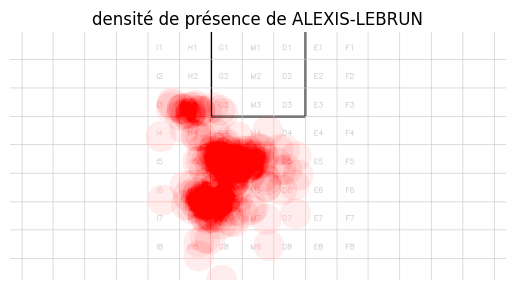

In [96]:
afficher_densite_frappes(annotations)

### Toutes frappes sur la table

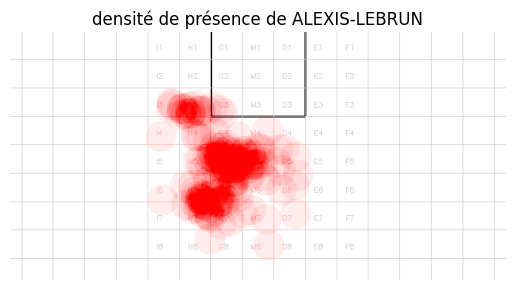

In [97]:
df = pd.read_sql_query(requete, con)
annotations_frappes_reussies = df[df["coor_balle_x"].notna()].values.tolist()

afficher_densite_frappes(annotations_frappes_reussies)

### Toutes frappes ratées

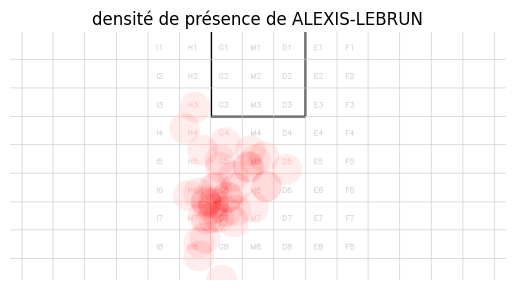

In [98]:
df = pd.read_sql_query(requete, con)
annotations_frappes_rates = df[df["coor_balle_x"].isna()].values.tolist()

afficher_densite_frappes(annotations_frappes_rates)

### Balles atteintes

In [99]:
df_qualite = pd.read_csv("C:/Users/ReViVD/Desktop/dataroom/pipeline-tt/2024_WttSmash_Singapour/ALEXIS-LEBRUN_vs_MA-LONG/ALEXIS-LEBRUN_vs_MA-LONG_annotation_qualite.csv")

0
[[4, 5], [13, 3], [16, 7], [16, 9], [20, 3], [29, 5], [29, 7], [33, 5], [37, 3], [44, 2], [45, 4], [55, 5], [62, 9], [62, 11], [67, 9]]


(-0.5, 799.5, 399.5, -0.5)

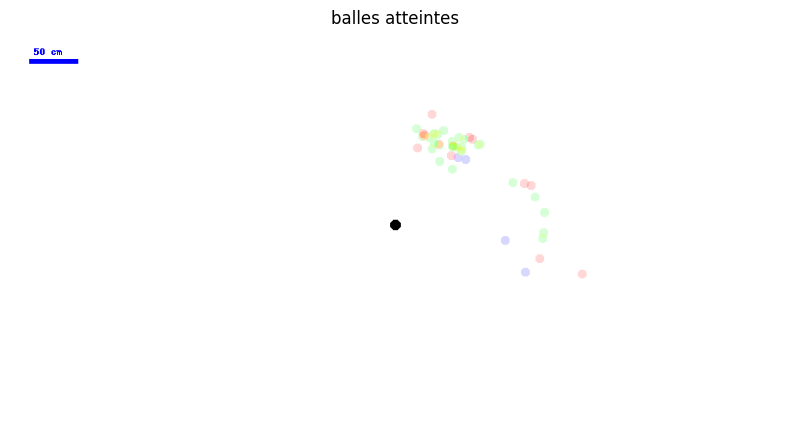

In [100]:
height, width = 400, 800
size=5
image_jA=np.ones((height, width,3), np.uint8)*255
image_jA=Image.fromarray(image_jA)
image_jB=image_jA.copy()
draw_jA = ImageDraw.Draw(image_jA)
draw_jB = ImageDraw.Draw(image_jB)
xj, yj = width/2, height/2
draw_jA.ellipse((xj - size, yj - size, xj + size, yj + size), fill="black")
draw_jB.ellipse((xj - size, yj - size, xj + size, yj + size), fill="black")

set_point=[] # num set, num pt
set_point.append([1,0])
for i in range(2,len(annotations)):
    if annotations[i][52+decalage_index_bdd]!=annotations[i-1][52+decalage_index_bdd]:
        set_point.append([int(annotations[i][5+decalage_index_bdd]), int(annotations[i][52+decalage_index_bdd])])

coord=[] #xj, yj, xb, yb
#for i in range(len(set_point)): #on boucle sur le nb de pts au cours du match
#    chemin='{}/{}/{}/clips/set_{}_point_{}'.format(chemin_pipeline,compet, match, set_point[i][0], set_point[i][1])

"""with open('{}/set_{}_point_{}_annotation.csv'.format(chemin, set_point[i][0], set_point[i][1]), newline='') as fichier :
    set_point_annotation=[]
    reader=csv.reader(fichier)
    for ligne in reader :
        set_point_annotation.append(ligne)"""

set_point_annotation = annotations

time_frappe=[] #frame de frappe (sachant que les num de frame reviennent à 0 à chaque début de point dans les clips)
"""for j in range(1, len(set_point_annotation)):
    if set_point_annotation[j][8+decalage_index_bdd]=='' or set_point_annotation[j][8+decalage_index_bdd]==None: # on ne prend pas les services
        #print(set_point_annotation[j][21+decalage_index_bdd])
        time_frappe.append(int(set_point_annotation[j][21+decalage_index_bdd]))"""

"""with open('{}/csv_json_openpose/set_{}_point_{}_zone_joueur_avec_pos_balle.csv'.format(chemin, set_point[i][0], set_point[i][1]), newline='') as fichier :
    set_point_pose=[]
    reader=csv.reader(fichier)
    for ligne in reader :
        set_point_pose.append(ligne)"""
print(len(time_frappe))
for j in range(len(set_point_annotation)):
    #print(set_point_annotation[j])
    pos_joueur_0_frappe_y = 70+decalage_index_bdd
    pos_joueur_0_frappe_x = 69+decalage_index_bdd
    coor_frappe_y = 19+decalage_index_bdd
    coor_frappe_x = 18+decalage_index_bdd
    pos_joueur_1_frappe_y = 73+decalage_index_bdd
    pos_joueur_1_frappe_x = 72+decalage_index_bdd
    lateralite = 4+decalage_index_bdd
    effet_coup = 12+decalage_index_bdd
    winner = 28+decalage_index_bdd
    num_point = 53+decalage_index_bdd
    num_coup = 27+decalage_index_bdd
    num_set = 5+decalage_index_bdd
    debut = 1+decalage_index_bdd
    if float(set_point_annotation[j][pos_joueur_0_frappe_y]) * float(set_point_annotation[j][coor_frappe_y]) >0 : # ie j0 et balle du même côté de la table
        if -float(set_point_annotation[j][coor_frappe_y]) >0 : # et du côté des y positifs
            coord.append([-float(set_point_annotation[j][pos_joueur_0_frappe_x]), float(set_point_annotation[j][pos_joueur_0_frappe_y]), -float(set_point_annotation[j][coor_frappe_x]), float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
        elif -float(set_point_annotation[j][coor_frappe_y]) <0 :
            coord.append([float(set_point_annotation[j][pos_joueur_0_frappe_x]), -float(set_point_annotation[j][pos_joueur_0_frappe_y]), float(set_point_annotation[j][coor_frappe_x]), -float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
    elif float(set_point_annotation[j][pos_joueur_1_frappe_y]) * float(set_point_annotation[j][coor_frappe_y]) >0 :
        if -float(set_point_annotation[j][coor_frappe_y]) >0 :
            coord.append([-float(set_point_annotation[j][pos_joueur_1_frappe_x]), float(set_point_annotation[j][pos_joueur_1_frappe_y]), -float(set_point_annotation[j][coor_frappe_x]), float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
        elif -float(set_point_annotation[j][coor_frappe_y]) <0 :
            coord.append([float(set_point_annotation[j][pos_joueur_1_frappe_x]), -float(set_point_annotation[j][pos_joueur_1_frappe_y]), float(set_point_annotation[j][coor_frappe_x]), -float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
    

qualite_coup_liste = df_qualite["qualite_coup"].tolist()

atteintes = []
for i in range(len(coord)):
    atteintes.append([float(coord[i][2]-coord[i][0]), float(coord[i][3]-coord[i][1]),coord[i][4],coord[i][5],coord[i][6],coord[i][7],coord[i][8],coord[i][9],df_qualite[(df_qualite["debut"] == coord[i][10])]["qualite_coup"].iloc[0]])



im=image_jA.copy()
px=im.load()

R=5
liste_derriere = []
for i in range(len(atteintes)):
    xb, yb = atteintes[i][0] +xj, -atteintes[i][1] +yj
    if yb > yj and atteintes[i][6] != 1:
        #print(atteintes[i][5],atteintes[i][6])
        liste_derriere.append([atteintes[i][5],atteintes[i][6]])
    for l in range(2*R):
        for L in range(2*R):
            if (L-R)**2+(l-R)**2<R**2:
                if xb+L-R<width and yb+l-R<height and xb+L-R>0 and yb+l-R>0:
                    g=int(px[xb+L-R,yb+l-R][1]-40)
                    b=int(px[xb+L-R,yb+l-R][2]-40)
                    if g>0 and b>0 and atteintes[i][6] != 1 and (atteintes[i][7] == 1 or atteintes[i][7] == 3) and atteintes[i][3] == "topspin":# and atteintes[i][5] == 33 and atteintes[i][6] == 5: 
                        """if atteintes[i][3] == "topspin" and atteintes[i][2] == "coup_droit":
                            couleur = (255,g,b)
                        elif atteintes[i][3] == "topspin" and atteintes[i][2] == "revers":
                            couleur = (g,b,255)
                        else:
                            continue"""

                        if atteintes[i][8] == -1:
                            couleur = (255,g,b)
                        elif atteintes[i][8] == 0:
                            couleur = (g,b,255)
                        else:
                            couleur = (g,255,b)
                        im.putpixel([int(xb+L-R),int(yb+l-R)],couleur)
                        px=im.load()
    draw=ImageDraw.Draw(im)
    draw.line([(20,30),(70,30)], fill='blue', width=5)
    #im.save('output/match_{}/nuage/nuage_{}.png'.format(match, i))
print(liste_derriere)
draw.text((25,15), '50 cm', fill='blue')
plt.figure(figsize=(10,5))
plt.imshow(im)
plt.title('balles atteintes')
plt.axis('off')

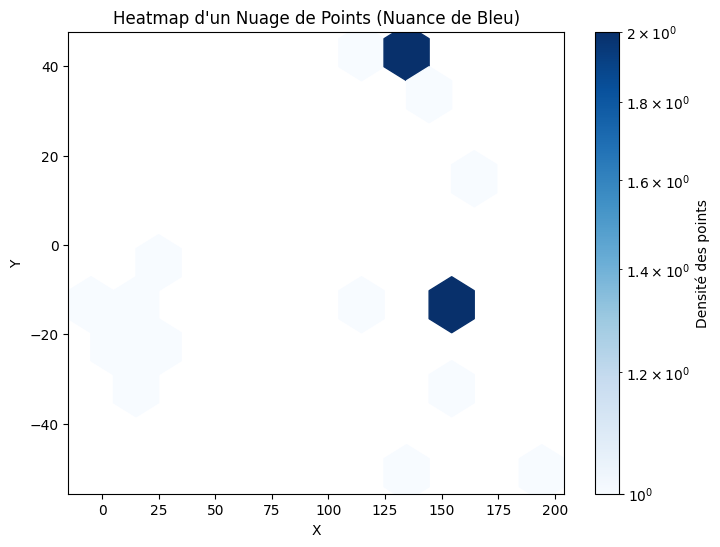

In [101]:

atteintes_filtre = []
for i in range(len(atteintes)):
    if atteintes[i][6] != 1 and  atteintes[i][3] == "topspin" and  atteintes[i][2] == "coup_droit":
        atteintes_filtre.append(atteintes[i])

x = [atteintes_filtre[i][0] for i in range(len(atteintes_filtre))]
y = [atteintes_filtre[i][1] for i in range(len(atteintes_filtre))]

# Création de la heatmap avec une colormap bleue
plt.figure(figsize=(8, 6))
plt.hexbin(x, y, gridsize=10, cmap='Blues', bins='log')  # Utilisation de la colormap "Blues"

# Ajout de la barre de couleur
plt.colorbar(label="Densité des points")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Heatmap d'un Nuage de Points (Nuance de Bleu)")

plt.show()


[[122.51548338  43.06060992]
 [ -4.90846376 -12.07622503]
 [  0.81502714 -26.62390366]
 [  8.01666908 -34.52210058]
 [135.07351265 -49.5374251 ]
 [194.32275238 -51.02488658]
 [141.84652588  40.56925394]
 [134.65564912  42.47000679]]


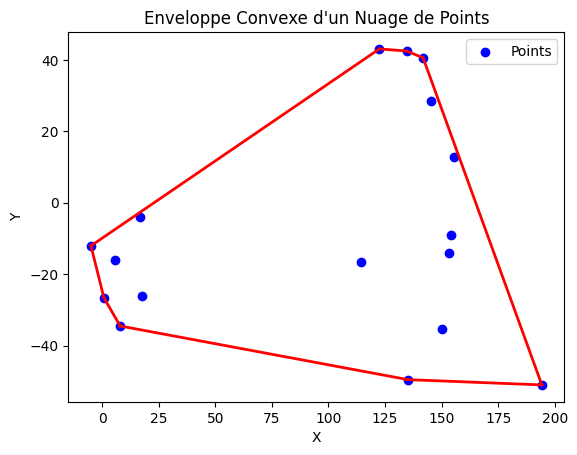

In [102]:
from scipy.spatial import ConvexHull

# Génération d'un ensemble de points aléatoires
np.random.seed(42)
points = np.random.rand(30, 2) * 10  # 30 points dans un carré de 10x10
points = np.array([[x[i],y[i]] for i in range(len(x))])


# Calcul de l'enveloppe convexe
hull = ConvexHull(points)
hull_points = points[hull.vertices]

df = pd.DataFrame(hull_points, columns=["X", "Y"])

# Sauvegarde dans un fichier CSV
df.to_csv("enveloppe_convexe.csv", index=False)


print(hull_points)

# Affichage des points
plt.scatter(points[:, 0], points[:, 1], label="Points", color="blue")

# Tracé de l'enveloppe convexe
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], "r-", linewidth=2)  # Tracé des arêtes en rouge

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Enveloppe Convexe d'un Nuage de Points")
plt.legend()
plt.show()


### Enregistrement enveloppe joueur

In [111]:
competition = "2024_WttSmash_Singapour"
match = "ALEXIS-LEBRUN_vs_MA-LONG"
if not os.path.isdir(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],competition,match,"enveloppe")):
    os.mkdir(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],competition,match,"enveloppe"))
atteintes_filtre = []
for i in range(len(atteintes)):
    if atteintes[i][6] != 1:
        atteintes_filtre.append(atteintes[i])

x = [atteintes_filtre[i][0] for i in range(len(atteintes_filtre))]
y = [atteintes_filtre[i][1] for i in range(len(atteintes_filtre))]


points = np.random.rand(30, 2) * 10  # 30 points dans un carré de 10x10
points = np.array([[x[i],y[i]] for i in range(len(x))])

# Calcul de l'enveloppe convexe
hull = ConvexHull(points)
hull_points = points[hull.vertices]

df = pd.DataFrame(hull_points, columns=["X", "Y"])

# Sauvegarde dans un fichier CSV
df.to_csv(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],competition,match,"enveloppe",match+"_"+joueurA+"_tous_enveloppe.csv"), index=False)


for qualite in [0,1,-1]:
    for coup in ['coup_droit','revers']:
        for effet in ['topspin',"bloc","poussette","flip"]:
            atteintes_filtre = []
            for i in range(len(atteintes)):
                if atteintes[i][6] != 1 and  atteintes[i][3] == effet and  atteintes[i][2] == coup and atteintes[i][8] == qualite:
                    atteintes_filtre.append(atteintes[i])
            if len(atteintes_filtre) >3:
                x = [atteintes_filtre[i][0] for i in range(len(atteintes_filtre))]
                y = [atteintes_filtre[i][1] for i in range(len(atteintes_filtre))]


                points = np.random.rand(30, 2) * 10  # 30 points dans un carré de 10x10
                points = np.array([[x[i],y[i]] for i in range(len(x))])

                # Calcul de l'enveloppe convexe
                hull = ConvexHull(points)
                hull_points = points[hull.vertices]
                print(hull_points)
                print(qualite,effet,coup)
                print("eeeeeeeee")
                df = pd.DataFrame(hull_points, columns=["X", "Y"])
                if qualite == -1:
                    qualite = "nulle"
                # Sauvegarde dans un fichier CSV
                df.to_csv(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],competition,match,"enveloppe",match+"_"+joueurA+"_"+coup+"_"+effet+"_"+"qualite_"+str(qualite)+"_enveloppe.csv"), index=False)



for coup in ['coup_droit','revers']:
    for effet in ['topspin',"bloc","poussette","flip"]:
        atteintes_filtre = []
        for i in range(len(atteintes)):
            if atteintes[i][6] != 1 and  atteintes[i][3] == effet and  atteintes[i][2] == coup:
                atteintes_filtre.append(atteintes[i])

        x = [atteintes_filtre[i][0] for i in range(len(atteintes_filtre))]
        y = [atteintes_filtre[i][1] for i in range(len(atteintes_filtre))]


        points = np.random.rand(30, 2) * 10  # 30 points dans un carré de 10x10
        points = np.array([[x[i],y[i]] for i in range(len(x))])

        # Calcul de l'enveloppe convexe
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]

        df = pd.DataFrame(hull_points, columns=["X", "Y"])

        # Sauvegarde dans un fichier CSV
        df.to_csv(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],competition,match,"enveloppe",match+"_"+joueurA+"_"+coup+"_"+effet+"_enveloppe.csv"), index=False)


[[-12.38944244 107.81059583]
 [-28.74050789 100.15288417]
 [-24.51677036  94.14936981]
 [-13.78612823  89.81546834]
 [ 84.21295834  85.06150257]
 [ 90.78065777  85.30549653]
 [ 89.35013208  97.41839886]]
0 poussette coup_droit
eeeeeeeee
[[-6.18019409 83.98086675]
 [99.41208801 82.12976545]
 [70.58363228 89.61279532]
 [19.63503189 95.23638738]]
0 flip coup_droit
eeeeeeeee
[[ 25.1332016  105.02446254]
 [-62.42692714  71.90412432]
 [-41.4263092   48.11659444]
 [ 82.5240551   54.87597882]]
0 bloc revers
eeeeeeeee
[[ 37.20871696 100.06794265]
 [-61.55715638  98.04284566]
 [ 57.61700783  89.80848076]
 [ 64.20722227  91.76068207]]
0 poussette revers
eeeeeeeee
[[122.51548338  43.06060992]
 [ -4.90846376 -12.07622503]
 [  8.01666908 -34.52210058]
 [153.40017319 -14.16895914]
 [154.14046421  -8.96618258]
 [155.60370579  12.83294784]
 [145.30892582  28.51473016]]
1 topspin coup_droit
eeeeeeeee
[[ 59.74262238  57.50793691]
 [ 88.08552456  83.76126696]
 [ 50.48954582  97.67345478]
 [-19.88633671 10

In [86]:
width, height = 800, 800

# Création d'une image blanche
image = np.ones((height, width, 3), dtype=np.uint8) * 255

coup = "coup_droit"
effet = "topspin"
df = pd.read_csv(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],competition,match,"enveloppe",match+"_"+joueurA+"_"+coup+"_"+effet+"_enveloppe.csv"))  # Remplace par le bon nom de fichier
print(df)
df["X"] += width//2
df["Y"] = -df["Y"]
df["Y"] += height//2
print(df)
# Convertir les colonnes en array NumPy
points = df[['X', 'Y']].values.astype(np.int32)  # Conversion en entier


# Calcul de l'enveloppe convexe
hull = ConvexHull(points)
hull_points = points[hull.vertices]  # Sommets de l'enveloppe convexe

# Convertir les points pour OpenCV (format requis)
hull_pts_cv2 = hull_points.reshape((-1, 1, 2))  # Reshape pour OpenCV

# Colorier l'intérieur de l'enveloppe en bleu
cv2.fillPoly(image, [hull_pts_cv2], (255, 150, 150))

# Affichage de l'image
cv2.imwrite(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],competition,match,"enveloppe.png"), image)

            X          Y
0  122.515483  43.060610
1   -4.908464 -12.076225
2    0.815027 -26.623904
3    8.016669 -34.522101
4  135.073513 -49.537425
5  194.322752 -51.024887
6  141.846526  40.569254
7  134.655649  42.470007
            X           Y
0  522.515483  356.939390
1  395.091536  412.076225
2  400.815027  426.623904
3  408.016669  434.522101
4  535.073513  449.537425
5  594.322752  451.024887
6  541.846526  359.430746
7  534.655649  357.529993


True

In [130]:

from concave_hull import concave_hull

from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import splprep, splev

import alphashape

In [124]:
balles_frappees_jA, balles_frappees_jB = [], []
for i in range(len(atteintes)):
    if atteintes[i][6] != 1:
        balles_frappees_jA.append(np.array([atteintes[i][0]+xj, atteintes[i][1]+yj]))
balles_frappees_jA=np.array(balles_frappees_jA)

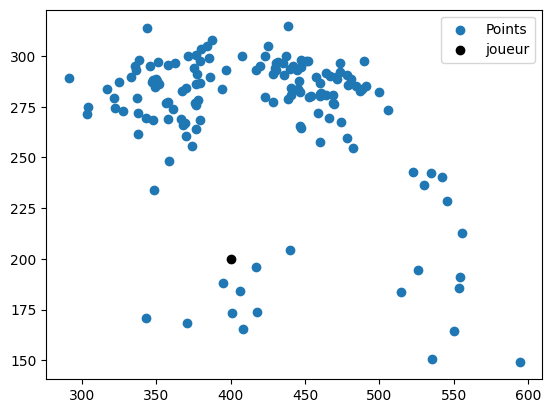

In [125]:
# méthode 1 : concave_hull

hull_points_jA=concave_hull(balles_frappees_jA)

plt.scatter(balles_frappees_jA[:, 0], balles_frappees_jA[:, 1], label='Points')
plt.scatter(400,200, color='k', label='joueur')
#plt.plot(hull_points_jA[:, 0], hull_points_jA[:, 1], 'r--', lw=2, label='Concave Hull')
#plt.fill(hull_points_jA[:, 0], hull_points_jA[:, 1], 'r', alpha=0.1)
plt.legend()
plt.show()

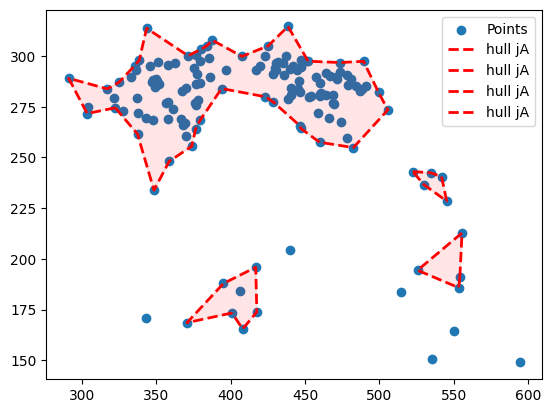

In [136]:
# méthode 2 : alphashape

alpha = 0.053
hull_points_jA = alphashape.alphashape(balles_frappees_jA, alpha)

def plot_polygon(ax, polygon, color='r', alpha=0.1):
    if isinstance(polygon, Polygon):
        hull_points = np.array(polygon.exterior.coords)
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'r--', lw=2, label='hull jA')
        ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.1)
    elif isinstance(polygon, MultiPolygon):
        for poly in polygon.geoms:
            plot_polygon(ax, poly, color, alpha)

fig, ax = plt.subplots()
ax.scatter(balles_frappees_jA[:, 0], balles_frappees_jA[:, 1], label='Points')
plot_polygon(ax, hull_points_jA)
ax.legend()
plt.show()

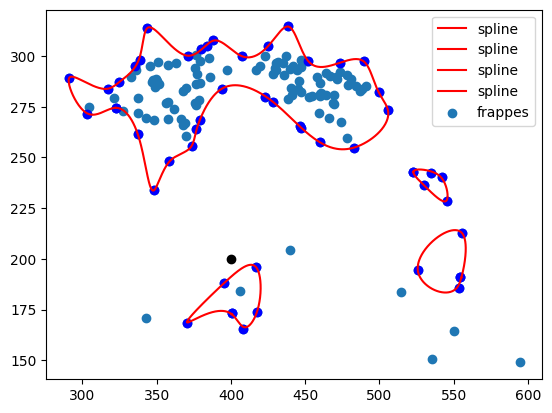

In [137]:
# méthode 2 avancée : lissage par splines

contour_points_liste = []
if isinstance(hull_points_jA, Polygon):
    contour_points_liste.append(np.array(hull_points_jA.exterior.coords))
elif isinstance(hull_points_jA, MultiPolygon):
    for poly in hull_points_jA.geoms:
        contour_points_liste.append(np.array(poly.exterior.coords))

x, y = [], []
for contour_points in contour_points_liste:
    tck, u = splprep([contour_points[:, 0], contour_points[:, 1]], s=2.0, per=True)
    u_nouv = np.linspace(u.min(), u.max(), 1000)
    x_nouv, y_nouv = splev(u_nouv, tck)
    x.append(x_nouv)
    y.append(y_nouv)

fig,ax=plt.subplots()
for contour_points in contour_points_liste:
    plt.plot(contour_points[:, 0], contour_points[:, 1], 'o', color='blue')
for x_nouv, y_nouv in zip(x, y):
    plt.plot(x_nouv, y_nouv, '-', label='spline', color='red')
ax.scatter(balles_frappees_jA[:, 0], balles_frappees_jA[:, 1], color='tab:blue', label='frappes')
ax.scatter(400,200,color='k')
plt.legend()
plt.show()

In [112]:
df_qualite

,nom,debut,fin,genre,lateralite,set,systeme,coup,type_service,type_coup,...,coor_frappe_x,coor_frappe_y,coor_frappe_z,time_frappe,premier_rebond_x,premier_rebond_y,premier_rebond_z,time_premier_rebond,probleme_annotation,qualite_coup
0,ALEXIS-LEBRUN,0,57,garcon,coup_droit,1,att/att,ALEXIS-LEBRUN,lat_droit,NaN,...,5.203843,-154.060450,100,45,55.728149,-85.212553,2.0,48.0,NaN,0
1,MA-LONG,58,72,garcon,coup_droit,1,att/att,MA-LONG,NaN,defensif,...,-18.375747,101.042517,100,62,NaN,NaN,NaN,NaN,NaN,0
2,ALEXIS-LEBRUN,73,82,garcon,revers,1,att/att,ALEXIS-LEBRUN,NaN,offensif,...,19.116692,-159.267667,100,76,NaN,NaN,NaN,NaN,NaN,1
3,MA-LONG,83,91,garcon,coup_droit,1,att/att,serveur_point_contre,NaN,intermediaire,...,-14.326147,229.941206,100,86,NaN,NaN,NaN,NaN,NaN,1
4,ALEXIS-LEBRUN,322,339,garcon,coup_droit,1,att/att,ALEXIS-LEBRUN,lat_droit,NaN,...,-9.465326,-178.933525,100,325,13.328049,-71.058141,2.0,329.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,MA-LONG,18267,18276,garcon,revers,2,att/att,MA-LONG,NaN,intermediaire,...,21.621306,-143.564130,100,18268,NaN,NaN,NaN,NaN,NaN,0
184,ALEXIS-LEBRUN,18277,18290,garcon,coup_droit,2,att/att,ALEXIS-LEBRUN,NaN,offensif,...,-58.197999,266.395869,100,18284,NaN,NaN,NaN,NaN,NaN,1
185,MA-LONG,18291,18307,garcon,coup_droit,2,att/att,serveur_point_pour,NaN,intermediaire,...,-122.748459,-271.793874,100,18293,NaN,NaN,NaN,NaN,NaN,-1
186,ALEXIS-LEBRUN,18539,18566,garcon,coup_droit,3,att/att,ALEXIS-LEBRUN,lat_droit,NaN,...,50.326198,-160.472281,100,18554,51.246858,-96.431563,2.0,18557.0,NaN,0


### Stats

Section présentant les différentes statisques au niveau des frappes

In [11]:
print("Nombre de coups effectués par " + joueurA + " :" + str(len(df)))
print("Nombre de coups effectués par " + joueurA + " sur la table:" + str(len(df[df["coor_balle_x"].notna()])))
print("Nombre de coups effectués par " + joueurA + " fautes:" + str(len(df[df["coor_balle_x"].isna()])))


Nombre de coups effectués par ALEXIS-LEBRUN :184
Nombre de coups effectués par ALEXIS-LEBRUN sur la table:146
Nombre de coups effectués par ALEXIS-LEBRUN fautes:38


Stats sur la qualité des coups

In [ ]:

print("Nombre de coups effectués par Alexis qualité -1: "+ str(len(df_qualite[(df_qualite["nom"] == "ALEXIS-LEBRUN") & (df_qualite["qualite_coup"] == -1)])))
print("Nombre de coups effectués par Alexis qualité 0: "+ str(len(df_qualite[(df_qualite["nom"] == "ALEXIS-LEBRUN") & (df_qualite["qualite_coup"] == 0)])))
print("Nombre de coups effectués par Alexis qualité 1: "+ str(len(df_qualite[(df_qualite["nom"] == "ALEXIS-LEBRUN") & (df_qualite["qualite_coup"] == 1)])))


print("Nombre de coups effectués par Ma Long qualité -1: "+ str(len(df_qualite[(df_qualite["nom"] != "ALEXIS-LEBRUN") & (df_qualite["qualite_coup"] == -1)])))
print("Nombre de coups effectués par Ma Long qualité 0: "+ str(len(df_qualite[(df_qualite["nom"] != "ALEXIS-LEBRUN") & (df_qualite["qualite_coup"] == 0)])))
print("Nombre de coups effectués par Ma Long qualité 1: "+ str(len(df_qualite[(df_qualite["nom"] != "ALEXIS-LEBRUN") & (df_qualite["qualite_coup"] == 1)])))

Nombre de coups effectués par Alexis qualité -1: 47
Nombre de coups effectués par Alexis qualité 0: 71
Nombre de coups effectués par Alexis qualité 1: 66
Nombre de coups effectués par Ma Long qualité -1: 38
Nombre de coups effectués par Ma Long qualité 0: 81
Nombre de coups effectués par Ma Long qualité 1: 57


In [72]:
len(df_qualite["qualite_coup"].tolist())

188

In [74]:
df_qualite.iloc[57]

nom                         ALEXIS-LEBRUN
debut                                5302
fin                                  5322
genre                              garcon
lateralite                     coup_droit
set                                     1
systeme                           att/att
coup                   serveur_point_pour
type_service                          NaN
type_coup                        offensif
zone_jeu                              NaN
faute                                 out
effet_coup                           flip
coor_balle_x                          NaN
coor_balle_y                          NaN
coor_balle_z                          NaN
joueur_frappe               ALEXIS-LEBRUN
joueur_sur                        MA-LONG
coor_frappe_x                 -118.412033
coor_frappe_y                 -111.254758
coor_frappe_z                         100
time_frappe                          5307
premier_rebond_x                      NaN
premier_rebond_y                  

### Modèles d'occupation

In [ ]:
def nuage_frappes(annotations):
    """with open('{}/{}/{}/{}_annotation_enrichi.csv'.format(chemin_pipeline, compet, match, match), newline='') as fichier_annotations :
        annotations=[]
        reader=csv.reader(fichier_annotations)
        for ligne in reader :
            annotations.append(ligne)"""

    with open('{}/{}/{}/{}_game.json'.format(chemin_pipeline, annotations[0][1], annotations[0][2], annotations[0][2]),  newline='') as fichier_game:
        data=json.load(fichier_game)
        game=[[cle,val] for cle,val in data.items()]
        joueurA=game[0][1]
        joueurB=game[1][1]


    im_jA = Image.new('RGB', (800, 400), 'white')
    im_jB = Image.new('RGB', (800, 400), 'white')
    draw_jA = ImageDraw.Draw(im_jA)
    draw_jB = ImageDraw.Draw(im_jB)
    draw_jA.ellipse([400-10, 200-10, 400+10, 200+10], fill='black')
    draw_jB.ellipse([400-10, 200-10, 400+10, 200+10], fill='black')

    set_point=[]
    set_point.append([1,0])
    
    num_point = 53+decalage_index_bdd
    num_set = 5+decalage_index_bdd
    pos_joueur_0_debut_x = 63+decalage_index_bdd
    pos_joueur_0_debut_y = 64+decalage_index_bdd
    for i in range(2,len(annotations)):
        if annotations[i][num_point]!=annotations[i-1][num_point]:
            set_point.append([int(annotations[i][num_set]), int(annotations[i][num_point])])

    cote_j=[[1, annotations[1][pos_joueur_0_debut_x], annotations[1][pos_joueur_0_debut_y]]] # [[set, cote jA, cote jB], ...]
    for i in range(2, len(annotations)):
        if annotations[i][num_set]!=annotations[i-1][num_set] :
            cote_j.append([annotations[i][num_set], annotations[i][pos_joueur_0_debut_x], annotations[i][pos_joueur_0_debut_y]])

    coord_jA=[] # xj, yj, xb, yb, latéralité (CD / revers)
    coord_jB=[]

    for i in range(len(set_point)):
        chemin='{}/{}/{}/clips/set_{}_point_{}'.format(chemin_pipeline,  annotations[0][1], annotations[0][2], set_point[i][0], set_point[i][1])
        
        with open('{}/set_{}_point_{}_annotation.csv'.format(chemin, set_point[i][0], set_point[i][1]), newline='') as fichier :
            set_point_annotation=[]
            reader=csv.reader(fichier)
            for ligne in reader :
                set_point_annotation.append(ligne)

        time_frappe=[] # joueur qui frappe, frame de frappe, latéralité
        for j in range(1, len(set_point_annotation)):
            if set_point_annotation[j][8]=='': # on ne prend pas les services
                time_frappe.append([set_point_annotation[j][0], int(set_point_annotation[j][21]), set_point_annotation[j][4]])
        
        if os.path.exists('{}/csv_json_openpose/set_{}_point_{}_zone_joueur_avec_pos_balle_3D.csv'.format(chemin, set_point[i][0], set_point[i][1])): # parfois le fichier 3d n'a pas été créé
            
            with open('{}/csv_json_openpose/set_{}_point_{}_zone_joueur_avec_pos_balle_3D.csv'.format(chemin, set_point[i][0], set_point[i][1]), newline='') as fichier :
                set_point_pose=[]
                reader=csv.reader(fichier)
                for ligne in reader :
                    set_point_pose.append(ligne)

            if set_point_pose[1][1]=='0' and set_point_pose[2][1]=='1':
                for j in range(len(time_frappe)):
                    if time_frappe[j][0]==joueurA:
                        if cote_j[set_point[i][0]-1][1]=='bas':
                            if set_point_pose[time_frappe[j][1]*3+3][2]!='': #souvent à partir de la dernière frappe il n'y a plus les coordonnées de la balle donc je prends celles à la frame précédente
                                coord_jA.append([float(set_point_pose[time_frappe[j][1]*3+1][2]),-float(set_point_pose[time_frappe[j][1]*3+1][3]), float(set_point_annotation[j+2][18]), -float(set_point_annotation[j+2][19]), time_frappe[j][2]])
                        elif cote_j[set_point[i][0]-1][1]=='haut':
                            if set_point_pose[time_frappe[j][1]*3+3][2]!='':
                                coord_jA.append([-float(set_point_pose[time_frappe[j][1]*3+1][2]),float(set_point_pose[time_frappe[j][1]*3+1][3]), -float(set_point_annotation[j+2][18]), float(set_point_annotation[j+2][19]), time_frappe[j][2]])
                    elif time_frappe[j][0]==joueurB:
                        if cote_j[set_point[i][0]-1][2]=='bas':
                            if set_point_pose[time_frappe[j][1]*3+3][2]!='':
                                coord_jB.append([float(set_point_pose[time_frappe[j][1]*3+2][2]),-float(set_point_pose[time_frappe[j][1]*3+2][3]), float(set_point_annotation[j+2][18]), -float(set_point_annotation[j+2][19]), time_frappe[j][2]])
                        elif cote_j[set_point[i][0]-1][2]=='haut':
                            if set_point_pose[time_frappe[j][1]*3+3][2]!='':
                                coord_jB.append([-float(set_point_pose[time_frappe[j][1]*3+2][2]),float(set_point_pose[time_frappe[j][1]*3+2][3]), -float(set_point_annotation[j+2][18]), float(set_point_annotation[j+2][19]), time_frappe[j][2]])
            
            elif set_point_pose[1][1]=='1' and set_point_pose[2][1]=='0':
                for j in range(len(time_frappe)):
                    if time_frappe[j][0]==joueurA:
                        if cote_j[set_point[i][0]-1][1]=='bas':
                            if set_point_pose[time_frappe[j][1]*3+3][2]!='':
                                coord_jA.append([float(set_point_pose[time_frappe[j][1]*3+2][2]),-float(set_point_pose[time_frappe[j][1]*3+2][3]), float(set_point_annotation[j+2][18]), -float(set_point_annotation[j+2][19]), time_frappe[j][2]])
                        elif cote_j[set_point[i][0]-1][1]=='haut':
                            if set_point_pose[time_frappe[j][1]*3+3][2]!='':
                                coord_jA.append([-float(set_point_pose[time_frappe[j][1]*3+2][2]),float(set_point_pose[time_frappe[j][1]*3+2][3]), -float(set_point_annotation[j+2][18]), float(set_point_annotation[j+2][19]), time_frappe[j][2]])
                    elif time_frappe[j][0]==joueurB:
                        if cote_j[set_point[i][0]-1][2]=='bas':
                            if set_point_pose[time_frappe[j][1]*3+3][2]!='':
                                coord_jB.append([float(set_point_pose[time_frappe[j][1]*3+1][2]),-float(set_point_pose[time_frappe[j][1]*3+1][3]), float(set_point_annotation[j+2][18]), -float(set_point_annotation[j+2][19]), time_frappe[j][2]])
                        elif cote_j[set_point[i][0]-1][2]=='haut':
                            if set_point_pose[time_frappe[j][1]*3+3][2]!='':
                                coord_jB.append([-float(set_point_pose[time_frappe[j][1]*3+1][2]),float(set_point_pose[time_frappe[j][1]*3+1][3]), -float(set_point_annotation[j+2][18]), float(set_point_annotation[j+2][19]), time_frappe[j][2]])


        atteintes_jA=[] # x_joueur-balle, y_joueur-balle au moment de la frappe, latéralité
        atteintes_jB=[]

        for i in range(len(coord_jA)):
            atteintes_jA.append([float(coord_jA[i][2]-coord_jA[i][0]), float(coord_jA[i][3]-coord_jA[i][1]), coord_jA[i][4]])
        for i in range(len(coord_jB)):
            atteintes_jB.append([float(coord_jB[i][2]-coord_jB[i][0]), float(coord_jB[i][3]-coord_jB[i][1]), coord_jB[i][4]])


        height, width = 400, 800
        xj, yj = width/2, height/2

        for i in range(len(atteintes_jA)):
            xb, yb = atteintes_jA[i][0] +xj, -atteintes_jA[i][1] +yj
            if atteintes_jA[i][2]=='revers':
                draw_jA.text((xb,yb), 'x', font=ImageFont.truetype("arial.ttf", 20), fill='red')
            elif atteintes_jA[i][2]=='coup_droit':
                draw_jA.text((xb,yb), 'x', font=ImageFont.truetype("arial.ttf", 20), fill='blue')

        for i in range(len(atteintes_jB)):
            xb, yb = atteintes_jB[i][0] +xj, -atteintes_jB[i][1] +yj
            if atteintes_jB[i][2]=='revers':
                draw_jB.text((xb,yb), 'x', font=ImageFont.truetype("arial.ttf", 20), fill='red')
            elif atteintes_jB[i][2]=='coup_droit':
                draw_jB.text((xb,yb), 'x', font=ImageFont.truetype("arial.ttf", 20), fill='blue')

        im_jA.save('{}/output/match_{}/nuage/nuage_jA.png'.format(chemin_tt_espace, match))
        im_jB.save('{}/output/match_{}/nuage/nuage_jB.png'.format(chemin_tt_espace, match))



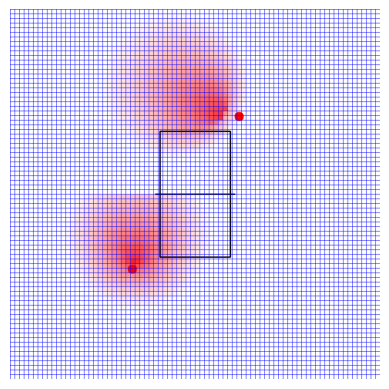

In [78]:
def tracer_table(): 

    w,h = 800, 800
    image = np.ones((h, w, 3), dtype=np.uint8) * 255  
    image = cv2.imread("C:/Users/ReViVD/Desktop/dataroom/pipeline-tt/2024_WttSmash_Singapour/ALEXIS-LEBRUN_vs_MA-LONG/clips/set_1_point_0/heatmap/image_48.png")
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    R=10

    cv2.line(image, (int(400-152/2), int(400-272/2)), (int(400+152/2), int(400-272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400-152/2), int(400-272/2)), (int(400-152/2), int(400+272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400+152/2), int(400+272/2)), (int(400+152/2), int(400-272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400+152/2), int(400+272/2)), (int(400-152/2), int(400+272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400-152/2-10), int(400)), (int(400+152/2+10), int(400)), (0, 0, 0), 2)


    cv2.circle(image, (int(400-136), int(400+162)), R, (255,0,0), -1)
    cv2.circle(image, (int(400+95), int(400-168)), R, (255,0,0), -1)

    espacement = 10
    image_size = 800
    epaisseur = 1
    
    for x in range(0, image_size, espacement):
        cv2.line(image, (x, 0), (x, image_size), couleur, epaisseur)

    for y in range(0, image_size, espacement):
        cv2.line(image, (0, y), (image_size, y), couleur, epaisseur)
        
    cv2.imwrite("C:/Users/ReViVD/Downloads/quadrillage.jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(image)
    plt.axis('off')
    #plt.title('densité de présence de {}'.format(joueurA))

tracer_table()